# 0.0 Import Librairies

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import eli5
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

from sklearn import metrics






# 0.1 Load the data

In [2]:
DATA_PATH = 'MDataFiles_Stage1/'

In [3]:
seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_season_results = pd.read_csv(DATA_PATH + 'MRegularSeasonDetailedResults.csv')
df_massey = pd.read_csv(DATA_PATH + "MMasseyOrdinals.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True)

# 1.1 Computing the average stats of each team during all the regular season they competed in

In [4]:
def prepare_data(df):
    win_df = df.copy()
    lose_df = df.copy()
    win_df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(win_df.columns)]
    lose_df.columns = [x.replace('W','T2_').replace('L','T1_') for x in list(lose_df.columns)]

    return pd.concat([win_df, lose_df], 0, sort=False)
    


A function that will be very usefull several times for us.

In [5]:
df_avg_stats = df_season_results.drop(['WLoc','NumOT'],axis = 1)
df_avg_stats['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_avg_stats = prepare_data(df_avg_stats)

/var/folders/3s/2snw8txj0118w4h7_5ldjpp80000gn/T/ipykernel_96489/1355792495.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([win_df, lose_df], 0, sort=False)


In [7]:
df_avg_stats= df_avg_stats.groupby(['Season','T1_TeamID']).mean().reset_index()

We just need the stats of the team we are looking at, so let's drop the useless columns.

In [8]:
df_avg_stats.drop(['DayNum', 'T1_Score', 'T2_TeamID', 'T2_Score','T2_FGM', 'T2_FGA',
       'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast',
       'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 'ScoreMargin'],axis = 1, inplace = True)

In [9]:
df_avg_stats

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF
0,2003,1102,19.142857,39.785714,7.821429,20.821429,11.142857,17.107143,4.178571,16.821429,13.000000,11.428571,5.964286,1.785714,18.750000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,19.037037,25.851852,9.777778,19.925926,15.222222,12.629630,7.259259,2.333333,19.851852
2,2003,1104,24.035714,57.178571,6.357143,19.857143,14.857143,20.928571,13.571429,23.928571,12.107143,13.285714,6.607143,3.785714,18.035714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,15.423077,21.846154,13.500000,23.115385,14.538462,18.653846,9.307692,2.076923,20.230769
4,2003,1106,23.428571,55.285714,6.107143,17.642857,10.642857,16.464286,12.285714,23.857143,11.678571,17.035714,8.357143,3.142857,18.178571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887,2022,1468,25.050000,54.850000,7.150000,22.100000,9.350000,12.550000,5.900000,20.650000,13.300000,9.750000,4.850000,1.600000,16.050000
6888,2022,1469,24.105263,58.473684,6.473684,21.631579,14.842105,21.473684,8.736842,23.631579,14.631579,15.052632,6.210526,2.315789,19.842105
6889,2022,1470,22.619048,54.904762,5.142857,16.666667,13.047619,17.571429,7.380952,19.095238,10.142857,10.190476,8.190476,2.142857,18.380952
6890,2022,1471,22.700000,52.400000,8.100000,23.700000,13.600000,18.600000,4.800000,21.950000,11.950000,13.250000,5.500000,1.600000,15.050000


Here is our tab with  the average stats of each team for all regular seasons since 2003.

# 1.2 Computing the WinRatio and the average gap score  of each team for all seasons they competed in

In [10]:
df_results= df_season_results.drop(['WLoc','NumOT'],axis = 1)
df_results['ScoreMargin'] = df_results['WScore'] - df_results['LScore']


Let's first compute : the number of wins, the number of losses, the gap score of each match and specify weither it is a won match or a losed match.

In [11]:
num_win = df_results.groupby(['Season','WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_losses = df_results.groupby(['Season','LTeamID']).count()
num_losses = num_losses.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
gap_win = df_results.groupby(['Season','WTeamID']).mean().reset_index()
gap_win = gap_win[['Season','WTeamID','ScoreMargin']].rename(columns = {'ScoreMargin' : 'Gap_Win' , 'WTeamID' : 'TeamID'})
gap_loss = df_results.groupby(['Season','LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season','LTeamID','ScoreMargin']].rename(columns = {'ScoreMargin' : 'Gap_Losses' , 'LTeamID' : 'TeamID'})



Let's merge if for each team each season

In [12]:
df_features_season_w = df_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_losses, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

/var/folders/3s/2snw8txj0118w4h7_5ldjpp80000gn/T/ipykernel_96489/1781378136.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


We can now compute now the stats we need,

In [13]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (df_features_season['NumWins']*df_features_season['Gap_Win'] - df_features_season['NumLosses']*df_features_season['Gap_Losses']) / (df_features_season['NumWins']+df_features_season['NumLosses'])

df_features_season.drop(['NumWins','NumLosses','Gap_Win','Gap_Losses'],axis = 1,inplace=True)

df_features_season['WinRatio']=df_features_season['WinRatio'].fillna(0)
df_features_season['GapAvg']=df_features_season['GapAvg'].fillna(0)

In [14]:
df_features_season

,Season,TeamID,WinRatio,GapAvg
0,2003,1102,0.428571,0.250000
1,2003,1103,0.481481,0.629630
2,2003,1104,0.607143,4.285714
3,2003,1105,0.269231,-4.884615
4,2003,1106,0.464286,-0.142857
...,...,...,...,...
6887,2022,1468,0.450000,-4.300000
6888,2022,1469,0.368421,-8.000000
6889,2022,1470,0.380952,-3.047619
6890,2022,1471,0.400000,-4.000000


Here is the tab that we aimed to create

# 2. Let's create now a dataset that is 'usable' to train a model

We are gonna train our networks on a large amount of matchs. Given the fact that we aim to create a model that is capable of predicting the issue of a match, we made the choice ton use the maximum data that is within our reach.
We are going to analyse all the matchs that have been played through regular seasons and tournaments since 2003, and group them in one dataset.

For each match, we are going to add to the initial data that is given by Kaggle, the average stats of the two teams during the regular season of the match, their average gap score and their win ratio. (For example, if a match has opposed Team A and Team B in the 2007 tournament, we will add as inputs, the average stats of Team A and Team B during the 2007 regular season,their average gap score and  their win ratio)

In order to do that, we are going to load:
the 'MNCAA Tourney Compact Results' which gives the data of all tournaments matchs played since 1985,
the 'MRegularSeason Compact Results' which gives data of all regular seadon matchs played since 1985

then add for each line(match) the average stats, winRation and AvgGap of each team.

And concatenate the two datasets in order to form one big dataset of matchs, from which we will extract our Train and Test datasets.

## Load the Tournament matchs and Seasons matchs

In [15]:
df_tourney_results = pd.read_csv(DATA_PATH + 'MNCAATourneyCompactResults.csv')
df_tourney_results.drop(['WLoc','NumOT'],axis=1,inplace=True)

In [16]:
df_results.drop(['WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF','ScoreMargin'],axis=1,inplace=True)

Here are all the regular season matchs since 2003

In [17]:
df_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2003,10,1104,68,1328,62
1,2003,10,1272,70,1393,63
2,2003,11,1266,73,1437,61
3,2003,11,1296,56,1457,50
4,2003,11,1400,77,1208,71
...,...,...,...,...,...,...
100418,2022,98,1400,79,1242,76
100419,2022,98,1411,66,1126,63
100420,2022,98,1422,68,1441,49
100421,2022,98,1438,69,1181,68


And the tournaments matchs

In [18]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38
...,...,...,...,...,...,...
2312,2021,148,1211,85,1425,66
2313,2021,148,1417,51,1276,49
2314,2021,152,1124,78,1222,59
2315,2021,152,1211,93,1417,90


Let's merge all the data for the tournaments matchs

In [19]:
df = df_tourney_results[df_tourney_results['Season'] >= 2003].reset_index(drop=True)

In [20]:
df = pd.merge(
    df, 
    seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})

df = pd.merge(
    df, 
    seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})

def treat_seed(seed):
    return int(seed[1:3])

df['WSeed'] = df['WSeed'].apply(treat_seed)
df['LSeed'] = df['LSeed'].apply(treat_seed)

df = pd.merge(df,
df_features_season,
how = 'left',
left_on=['Season','WTeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'WwinRatio' , 'GapAvg' : 'WGapAvg' } ).drop('TeamID',axis=1)

df = pd.merge(df,
df_features_season,
how = 'left',
left_on=['Season','LTeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'LwinRatio' , 'GapAvg' : 'LGapAvg' } ).drop('TeamID',axis=1)

avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

df = pd.merge(
   df,
     avg_ranking,
     how='left',
     left_on=['Season', 'WTeamID'],
     right_on=['Season', 'TeamID']
 ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'WOrdinalRank'})

df = pd.merge(
   df,
     avg_ranking,
     how='left',
     left_on=['Season', 'LTeamID'],
     right_on=['Season', 'TeamID']
 ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'LOrdinalRank'})

df = pd.merge(df,
df_avg_stats,
how = 'left',
left_on=['Season','WTeamID'],
right_on = ['Season','T1_TeamID'],
).rename(columns = {'T1_FGM' : 'WAvgFGM',	'T1_FGA' : 'WAvgFGA',	'T1_FGM3' : 'WAvgFGM3', 'T1_FGA3':'WAvgFGA3',	'T1_FTM':'WAvgFTM',	'T1_FTA':'WAvgFTA'	,'T1_OR':'WAvgOR',	'T1_DR':'WAvgDR',	'T1_Ast':'WAvgAst',	'T1_TO':'WAvgTO',	'T1_Stl':'WAvgStl',	'T1_Blk':'WAvgBlk',	'T1_PF':'WAvgPF' } ).drop('T1_TeamID',axis=1)

df = pd.merge(df,
df_avg_stats,
how = 'left',
left_on=['Season','LTeamID'],
right_on = ['Season','T1_TeamID'],
).rename(columns = {'T1_FGM' : 'LAvgFGM',	'T1_FGA' : 'LAvgFGA',	'T1_FGM3' : 'LAvgFGM3', 'T1_FGA3':'LAvgFGA3',	'T1_FTM':'LAvgFTM',	'T1_FTA':'LAvgFTA'	,'T1_OR':'LAvgOR',	'T1_DR':'LAvgDR',	'T1_Ast':'LAvgAst',	'T1_TO':'LAvgTO',	'T1_Stl':'LAvgStl',	'T1_Blk':'LAvgBlk',	'T1_PF':'LAvgPF' } ).drop('T1_TeamID',axis=1)


let's merge all the data for the regular season matchs (you can notice that we decided to give an arbitrary seed for each team that did not qualify for the tournament : 40)

In [21]:
df_2 = df_results.copy()

In [22]:
df_2 = pd.merge(
    df_2, 
    seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})

df_2 = pd.merge(
    df_2, 
    seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})

df_2['WSeed'] = df_2['WSeed'].fillna('W40U')
df_2['LSeed'] = df_2['LSeed'].fillna('W40U')

df_2['WSeed'] = df_2['WSeed'].apply(treat_seed)
df_2['LSeed'] = df_2['LSeed'].apply(treat_seed)


df_2 = pd.merge(df_2,
df_features_season,
how = 'left',
left_on=['Season','WTeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'WwinRatio' , 'GapAvg' : 'WGapAvg' } ).drop('TeamID',axis=1)

df_2 = pd.merge(df_2,
df_features_season,
how = 'left',
left_on=['Season','LTeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'LwinRatio' , 'GapAvg' : 'LGapAvg' } ).drop('TeamID',axis=1)


df_2 = pd.merge(df_2,
df_avg_stats,
how = 'left',
left_on=['Season','WTeamID'],
right_on = ['Season','T1_TeamID'],
).rename(columns = {'T1_FGM' : 'WAvgFGM',	'T1_FGA' : 'WAvgFGA',	'T1_FGM3' : 'WAvgFGM3', 'T1_FGA3':'WAvgFGA3',	'T1_FTM':'WAvgFTM',	'T1_FTA':'WAvgFTA'	,'T1_OR':'WAvgOR',	'T1_DR':'WAvgDR',	'T1_Ast':'WAvgAst',	'T1_TO':'WAvgTO',	'T1_Stl':'WAvgStl',	'T1_Blk':'WAvgBlk',	'T1_PF':'WAvgPF' } ).drop('T1_TeamID',axis=1)

df_2 = pd.merge(df_2,
df_avg_stats,
how = 'left',
left_on=['Season','LTeamID'],
right_on = ['Season','T1_TeamID'],
).rename(columns = {'T1_FGM' : 'LAvgFGM',	'T1_FGA' : 'LAvgFGA',	'T1_FGM3' : 'LAvgFGM3', 'T1_FGA3':'LAvgFGA3',	'T1_FTM':'LAvgFTM',	'T1_FTA':'LAvgFTA'	,'T1_OR':'LAvgOR',	'T1_DR':'LAvgDR',	'T1_Ast':'LAvgAst',	'T1_TO':'LAvgTO',	'T1_Stl':'LAvgStl',	'T1_Blk':'LAvgBlk',	'T1_PF':'LAvgPF' } ).drop('T1_TeamID',axis=1)


In [23]:
df = prepare_data(df)
df_2 = prepare_data(df_2)

/var/folders/3s/2snw8txj0118w4h7_5ldjpp80000gn/T/ipykernel_96489/1355792495.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([win_df, lose_df], 0, sort=False)


Let's add some interessant features

In [24]:
df['SeedDiff'] = df['T1_Seed'] - df['T2_Seed']
df['WinRatioDiff'] = df['T1_winRatio'] - df['T2_winRatio']
df['GapAvgDiff'] = df['T1_GapAvg'] - df['T2_GapAvg']
df['OrdinalRankDiff'] = df['T1_OrdinalRank'] - df['T2_OrdinalRank']

In [25]:
df_2['SeedDiff'] = df_2['T1_Seed'] - df_2['T2_Seed']
df_2['WinRatioDiff'] = df_2['T1_winRatio'] - df_2['T2_winRatio']
df_2['GapAvgDiff'] = df_2['T1_GapAvg'] - df_2['T2_GapAvg']
df_2['OrdinalRankDiff'] = 0

### Here is the final dataset

In [26]:
df= pd.concat([df, df_2], 0, sort=False)

/var/folders/3s/2snw8txj0118w4h7_5ldjpp80000gn/T/ipykernel_96489/2490820630.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df= pd.concat([df, df_2], 0, sort=False)


# 2.1 Creation of X_train,Y_train,X_test,Y_test

In [27]:
from sklearn.model_selection import train_test_split

import eli5



features = [
    'T1_winRatio', 'T1_GapAvg', 'T2_winRatio',
       'T2_GapAvg', 'T1_AvgFGM',
       'T1_AvgFGA', 'T1_AvgFGM3', 'T1_AvgFGA3', 'T1_AvgFTM', 'T1_AvgFTA',
       'T1_AvgOR', 'T1_AvgDR', 'T1_AvgAst', 'T1_AvgTO', 'T1_AvgStl',
       'T1_AvgBlk', 'T1_AvgPF', 'T2_AvgFGM', 'T2_AvgFGA', 'T2_AvgFGM3',
       'T2_AvgFGA3', 'T2_AvgFTM', 'T2_AvgFTA', 'T2_AvgOR', 'T2_AvgDR',
       'T2_AvgAst', 'T2_AvgTO', 'T2_AvgStl', 'T2_AvgBlk', 'T2_AvgPF',
       'SeedDiff', 'WinRatioDiff', 'GapAvgDiff', 'OrdinalRankDiff']

df['ScoreDiff'] = df['T1_Score'] - df['T2_Score']
y = (df['ScoreDiff'] > 0).astype(int)
X = df[features]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)


# 2.2 Pre-processing functions

# Let's build some models

In [28]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    
    print("   log_loss", round(metrics.log_loss(y_test.values,model.predict_proba(X_test)),2))


def evaluation_with_learning_curve(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    

    try:
        print("   log_loss", round(metrics.log_loss(y_test.values,model.predict_proba(X_test)),2))
    except:
        print(f"   Can't calculate log_loss for {model.steps[1][0]} !!")
    print("   f1 score " , round(f1_score(y_test,ypred),2))
    print("   roc auc score " ,  round(roc_auc_score(y_test,ypred),2))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred)
    
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()  
    plt.show()      

In [29]:
LogisticRegression = make_pipeline(StandardScaler(), LogisticRegression())
RandomForest = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(max_depth=10, random_state=0,n_estimators=100,bootstrap = True,)
)
XGB = make_pipeline(StandardScaler(),XGBClassifier())
AdaBoost = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=0))
MLP = make_pipeline(StandardScaler(), MLPClassifier(random_state=0))
SVC = make_pipeline(StandardScaler(), SVC())
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
KNN_ = make_pipeline(KNeighborsClassifier())
LinearDiscriminantAnalysis = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()) 
"""LinearDiscriminantAnalysis_Kbest = make_pipeline(
    StandardScaler(),
    SelectKBest(f_classif, k=10),
    LinearDiscriminantAnalysis()
) 
LinearDiscriminantAnalysis_PolynomialFeatures = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2, include_bias=False),
    LinearDiscriminantAnalysis(),
) """
GaussianNB = make_pipeline(StandardScaler(), GaussianNB()) 
MultinomialNB = make_pipeline(StandardScaler(), MultinomialNB())
ComplementNB = make_pipeline(StandardScaler(), ComplementNB())
BernoulliNB = make_pipeline(StandardScaler(), BernoulliNB())

After several tests, we have some models that perform better

In [147]:
dict_of_models = {
    'LogisticRegression': LogisticRegression,
    'RandomForest': RandomForest,
    'MLP': MLP,
    'XGB' : XGB,
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis,
    #'LinearDiscriminantAnalysis_Kbest': LinearDiscriminantAnalysis_Kbest,
    #'LinearDiscriminantAnalysis_PolynomialFeatures': LinearDiscriminantAnalysis_PolynomialFeatures,
}

LogisticRegression
   log_loss 0.51
   f1 score  0.74
   roc auc score  0.75


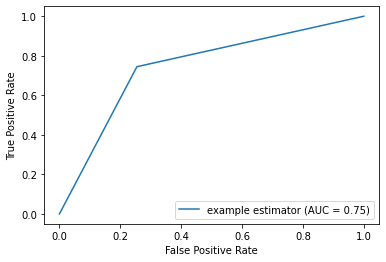

RandomForest
   log_loss 0.52
   f1 score  0.74
   roc auc score  0.74


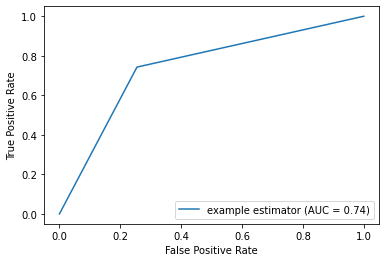

MLP
   log_loss 0.52
   f1 score  0.74
   roc auc score  0.74


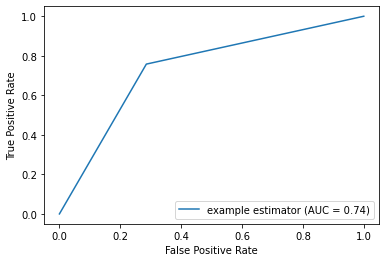

XGB
[18:58:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
   log_loss 0.52
   f1 score  0.74
   roc auc score  0.74


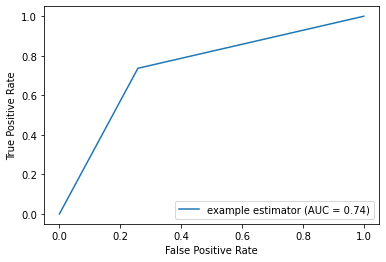

LinearDiscriminantAnalysis
   log_loss 0.52
   f1 score  0.74
   roc auc score  0.75


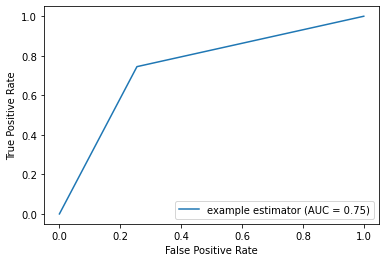

In [148]:
# pour éviter l'afficahge des warning
import warnings
warnings.filterwarnings("ignore")

for name, model in dict_of_models.items():
    print(name)
    evaluation_with_learning_curve(model)

# 3. Creating the submission file

In [33]:
sub = pd.read_csv(DATA_PATH + 'MSampleSubmissionStage1.csv')
sub.head()

,ID,Pred
0,2016_1112_1114,0.5
1,2016_1112_1122,0.5
2,2016_1112_1124,0.5
3,2016_1112_1138,0.5
4,2016_1112_1139,0.5


In [34]:
sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139


In [35]:
sub.shape

(11390, 5)

In [36]:
avg_stats = df_avg_stats.copy()
avg_stats.columns = [x.replace('T1_','') for x in list(avg_stats.columns)]

In [37]:
avg_stats.columns

Index(['Season', 'TeamID', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR',
       'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'],
      dtype='object')

In [38]:
sub = pd.merge(
    sub, 
    seeds, 
    how='left', 
    left_on=['Season', 'T1_TeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'T1_Seed'})

sub = pd.merge(
    sub, 
    seeds, 
    how='left', 
    left_on=['Season', 'T2_TeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'T2_Seed'})

def treat_seed(seed):
    return int(seed[1:3])

sub['T1_Seed'] = sub['T1_Seed'].apply(treat_seed)
sub['T2_Seed'] = sub['T2_Seed'].apply(treat_seed)

sub = pd.merge(sub,
df_features_season,
how = 'left',
left_on=['Season','T1_TeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'T1_winRatio' , 'GapAvg' : 'T1_GapAvg' } ).drop('TeamID',axis=1)

sub = pd.merge(sub,
df_features_season,
how = 'left',
left_on=['Season','T2_TeamID'],
right_on = ['Season','TeamID'],
).rename(columns = {'WinRatio' : 'T2_winRatio' , 'GapAvg' : 'T2_GapAvg' } ).drop('TeamID',axis=1)

sub = pd.merge(
   sub,
     avg_ranking,
     how='left',
     left_on=['Season', 'T1_TeamID'],
     right_on=['Season', 'TeamID']
 ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'T1_OrdinalRank'})

sub = pd.merge(
   sub,
     avg_ranking,
     how='left',
     left_on=['Season', 'T2_TeamID'],
     right_on=['Season', 'TeamID']
 ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'T2_OrdinalRank'})

sub = pd.merge(sub,
avg_stats,
how = 'left',
left_on=['Season','T1_TeamID'],
right_on = ['Season','TeamID']
).drop('TeamID',axis=1).rename(columns= {'FGM' : 'T1_AvgFGM',	'FGA' : 'T1_AvgFGA',	'FGM3' : 'T1_AvgFGM3', 'FGA3':'T1_AvgFGA3',	'FTM':'T1_AvgFTM',	'FTA':'T1_AvgFTA'	,'OR':'T1_AvgOR',	'DR':'T1_AvgDR',	'Ast':'T1_AvgAst',	'TO':'T1_AvgTO',	'Stl':'T1_AvgStl',	'Blk':'T1_AvgBlk',	'PF':'T1_AvgPF' })

sub = pd.merge(sub,
avg_stats,
how = 'left',
left_on=['Season','T2_TeamID'],
right_on = ['Season','TeamID'],
).drop('TeamID',axis=1).rename(columns = {'FGM' : 'T2_AvgFGM',	'FGA' : 'T2_AvgFGA',	'FGM3' : 'T2_AvgFGM3', 'FGA3':'T2_AvgFGA3',	'FTM':'T2_AvgFTM',	'FTA':'T2_AvgFTA'	,'OR':'T2_AvgOR',	'DR':'T2_AvgDR',	'Ast':'T2_AvgAst',	'TO':'T2_AvgTO',	'Stl':'T2_AvgStl',	'Blk':'T2_AvgBlk',	'PF':'T2_AvgPF' } )


In [39]:
sub['SeedDiff'] = sub['T1_Seed'] - sub['T2_Seed']
sub['WinRatioDiff'] = sub['T1_winRatio'] - sub['T2_winRatio']
sub['GapAvgDiff'] = sub['T1_GapAvg'] - sub['T2_GapAvg']
sub['OrdinalRankDiff'] = sub['T1_OrdinalRank'] - sub['T2_OrdinalRank']

In [40]:
sub.columns

Index(['ID', 'Pred', 'Season', 'T1_TeamID', 'T2_TeamID', 'T1_Seed', 'T2_Seed',
       'T1_winRatio', 'T1_GapAvg', 'T2_winRatio', 'T2_GapAvg',
       'T1_OrdinalRank', 'T2_OrdinalRank', 'T1_AvgFGM', 'T1_AvgFGA',
       'T1_AvgFGM3', 'T1_AvgFGA3', 'T1_AvgFTM', 'T1_AvgFTA', 'T1_AvgOR',
       'T1_AvgDR', 'T1_AvgAst', 'T1_AvgTO', 'T1_AvgStl', 'T1_AvgBlk',
       'T1_AvgPF', 'T2_AvgFGM', 'T2_AvgFGA', 'T2_AvgFGM3', 'T2_AvgFGA3',
       'T2_AvgFTM', 'T2_AvgFTA', 'T2_AvgOR', 'T2_AvgDR', 'T2_AvgAst',
       'T2_AvgTO', 'T2_AvgStl', 'T2_AvgBlk', 'T2_AvgPF', 'SeedDiff',
       'WinRatioDiff', 'GapAvgDiff', 'OrdinalRankDiff'],
      dtype='object')

In [41]:
features = [
    'T1_winRatio', 'T1_GapAvg', 'T2_winRatio',
       'T2_GapAvg', 'T1_AvgFGM',
       'T1_AvgFGA', 'T1_AvgFGM3', 'T1_AvgFGA3', 'T1_AvgFTM', 'T1_AvgFTA',
       'T1_AvgOR', 'T1_AvgDR', 'T1_AvgAst', 'T1_AvgTO', 'T1_AvgStl',
       'T1_AvgBlk', 'T1_AvgPF', 'T2_AvgFGM', 'T2_AvgFGA', 'T2_AvgFGM3',
       'T2_AvgFGA3', 'T2_AvgFTM', 'T2_AvgFTA', 'T2_AvgOR', 'T2_AvgDR',
       'T2_AvgAst', 'T2_AvgTO', 'T2_AvgStl', 'T2_AvgBlk', 'T2_AvgPF',
       'SeedDiff', 'WinRatioDiff', 'GapAvgDiff', 'OrdinalRankDiff']

In [42]:
Xsub = sub[features]
Ysub = RandomForest.predict_proba(Xsub)
sub['Pred'] = Ysub


In [43]:
sub[['ID','Pred']].to_csv("finalsubmission_RandomForest.csv", index = None)

In [60]:
'''from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
# Find the best parameters for the model
parameters = {
    'max_depth': [5,10],
    'n_estimators': [10,100],
    'bootstrap' : [True] , 
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = 1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_'''

Fitting 3 folds for each of 4 candidates, totalling 12 fits


{'bootstrap': True, 'max_depth': 10, 'n_estimators': 100}

In [62]:
'''# Log Loss
# Import library for metrics
from sklearn.metrics import log_loss


log_loss = log_loss(y_test.values,rf.predict_proba(X_test))

print('LogLoss :', round(log_loss,2) )'''

LogLoss : 0.52


In [233]:
'''def imp_df(column_names, importances):
     df = pd.DataFrame({'feature':column_names, 'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
     return(df)'''

In [234]:
'''from eli5.sklearn import PermutationImportance


perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)

print(perm_imp_eli5)'''

            feature  feature_importance
0   OrdinalRankDiff            0.002298
1        T2_Avg_Stl            0.001482
2        T1_Avg_Blk            0.000678
3    T2_OrdinalRank            0.000614
4    T1_OrdinalRank            0.000540
5         T1_AvgFGA            0.000529
6        T2_avg_Ast            0.000529
7        T1_avg_Ast            0.000529
8        T1_Avg_Stl            0.000487
9        GapAvgDiff            0.000476
10        T2_AvgFGM            0.000455
11       T2_Avg_Blk            0.000413
12        T1_AvgFGM            0.000381
13      T2_winRatio            0.000275
14        T2_GapAvg            0.000265
15        T2_AvgFGA            0.000244
16      T1_winRatio            0.000191
17          T1_Seed            0.000169
18        T1_GapAvg            0.000106
19        T1_Avg_DR            0.000021
20          T2_Seed            0.000000
21       T1_Avg_FTA            0.000000
22       T1_AvgFGM3            0.000000
23     WinRatioDiff            0.000000
